## Train networks with weighted loss function

Compare training performance between CNNs with and without 'attention'. Here, attention is defined by per-pixel weights generated in a preprocessing step.

### Load modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from pathlib import Path
import re

import numpy as np
%autoreload -numpy

from matplotlib import pyplot as plt
%autoreload -matplotlib
%autoreload -matplotlib.pyplot

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import tensorflow as tf

# The following overcomes a cuDNN bug with NVidia RTX cards
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))

from tensorflow.python.keras.models import Model
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import layers as KL
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
%autoreload -tensorflow

/home/alan/anaconda3/envs/cnn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alan/anaconda3/envs/cnn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alan/anaconda3/envs/cnn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/alan/anaconda3/envs/cnn/lib/python3.6/site-packages/ten

In [3]:
from baby.utils import PathEncoder
#from maby.preprocessing import raw_norm, logical_norm, robust_norm
from baby.augmentation import Augmenter
#from maby.generator import WeightedImageLabel as Generator
from baby.models import unet_block, msd_block
#from maby.losses import weighted_bce_dice, unweighted_bce_dice, unweighted_dice
from baby.visualise import plot_ims, colour_seg

### Initialise training data

**Find training images and define a train-validation split**

NB: do not run this block but the next one if a train-validation split has already been defined

In [4]:
base_dir = Path('~/Documents/TrainingTemp/181218_vph1').expanduser()
log_dir = Path('training-logs/190813_vacuole_test')

bf_pngs = list(base_dir.glob('**/*_brightfield.png'))
re_bf = re.compile(r'_brightfield\.png')
seg_pngs = [f.parent / re_bf.sub('_vacuole.png', f.name) for f in bf_pngs]
wght_pngs = [f.parent / re_bf.sub('_weights.png', f.name) for f in bf_pngs]
all_data = [(b, s, w) for b, s, w in zip(bf_pngs, seg_pngs, wght_pngs) if s.exists() and w.exists()]

re_pos_trap = re.compile(r'pos(\d{3})_trap(\d{3})')
all_data_pos_trap = [re_pos_trap.search(str(b)).groups() for b, _, _ in all_data]
unique_pos_trap = set(all_data_pos_trap)

# Choose a split that ensures separation by pos/trap and not time point
train_pos_trap, val_pos_trap = train_test_split(list(unique_pos_trap))
train_pos_trap, val_pos_trap = set(train_pos_trap), set(val_pos_trap)
train_data = [bsw for bsw, pt in zip(all_data, all_data_pos_trap) if pt in train_pos_trap]
val_data = [bsw for bsw, pt in zip(all_data, all_data_pos_trap) if pt in val_pos_trap]

# Save train-validation split:
with open(log_dir / 'train-val-split.json', 'w') as f:
    json.dump({'train_data': train_data, 'val_data': val_data}, f, cls=PathEncoder)

print('Out of {} training image sets, {} will be used for training and {} for validation'.format(
    len(all_data), len(train_data), len(val_data)))

Out of 5184 training image sets, 3888 will be used for training and 1296 for validation


**Load train-validation split**

Run this instead of the previous block if a train-validation split has already been defined

In [4]:
base_dir = Path('~/Documents/TrainingTemp/181218_vph1').expanduser()
log_dir = Path('training-logs/190813_vacuole_test')

# Load train-validation split:
with open(log_dir / 'train-val-split.json', 'r') as f:
    loaded_data = json.load(f)

train_data = loaded_data['train_data']
val_data = loaded_data['val_data']

print('Out of {} training image sets, {} will be used for training and {} for validation'.format(
    len(train_data) + len(val_data), len(train_data), len(val_data)))

Out of 5184 training image sets, 3888 will be used for training and 1296 for validation


**Define augmentations and data generators**

In [31]:
# Images are of size 117x117; choose Augmenter output size of 96x96 to allow for 5-stage U-net
train_aug = Augmenter(xy_out=96, probs={'rotate': 0.2, 'vshift': 0.25, 'hshift': 0.25, 'downscale': 0.2})
val_aug = Augmenter(xy_out=96, p_noop=1, probs={'vshift': 0.25, 'hshift': 0.25})

Batch input shape: (16, 96, 96, 5); Batch output shape: (16, 96, 96, 2)
Example input images:


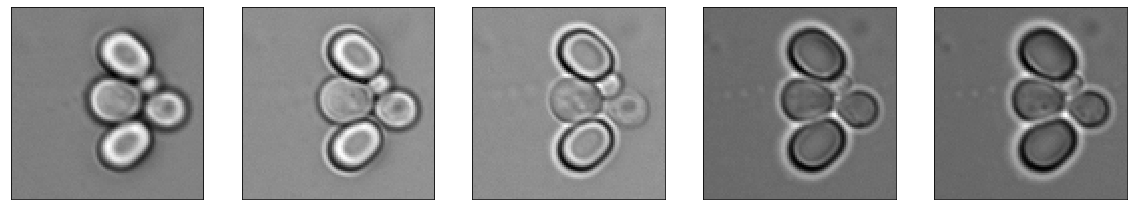

Example output images (target on left; weights on right):


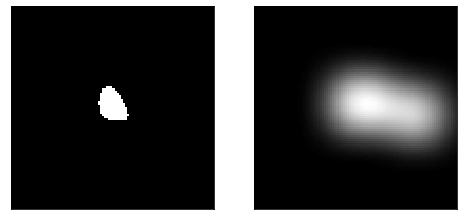

In [5]:
# Brightfield gets robust normalisation, vacuole is logical, and weights should be standard norm between [0,1]
preprocessing_funcs = (robust_norm, logical_norm, raw_norm)
train_gen = Generator(train_data, batch_size=16, aug=train_aug, preprocess=preprocessing_funcs, in_memory=True)
val_gen = Generator(val_data, batch_size=16, aug=val_aug, preprocess=preprocessing_funcs, in_memory=True)

img_batch, lbl_wght_batch = val_gen[0]
lbl_wght_batch = lbl_wght_batch[0]  # output is a list of length 1
print('Batch input shape: {}; Batch output shape: {}'.format(str(img_batch.shape), str(lbl_wght_batch.shape)))

print('Example input images:')
plot_ims(np.dsplit(img_batch[0], img_batch.shape[-1]))
print('Example output images (target on left; weights on right):')
plot_ims(np.dsplit(lbl_wght_batch[0], lbl_wght_batch.shape[-1]))

**Define data generators with inverted weights as a negative control**

Batch input shape: (16, 96, 96, 5); Batch output shape: (16, 96, 96, 2)
Example input images:


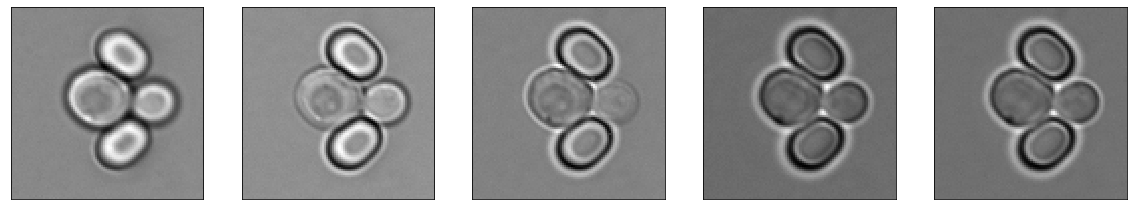

Example output images (target on left; weights on right):


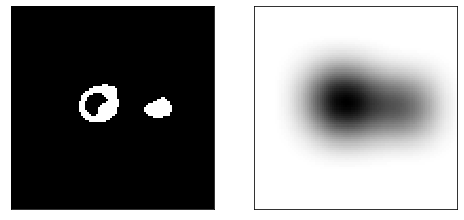

In [33]:
preprocessing_funcs = (robust_norm, logical_norm, lambda im, inf: 1-raw_norm(im, inf))
train_gen_winv = Generator(train_data, batch_size=16, aug=train_aug, preprocess=preprocessing_funcs, in_memory=True)
val_gen_winv = Generator(val_data, batch_size=16, aug=val_aug, preprocess=preprocessing_funcs, in_memory=True)

img_batch, lbl_wght_batch = val_gen_winv[0]
lbl_wght_batch = lbl_wght_batch[0]  # output is a list of length 1
print('Batch input shape: {}; Batch output shape: {}'.format(str(img_batch.shape), str(lbl_wght_batch.shape)))

print('Example input images:')
plot_ims(np.dsplit(img_batch[0], img_batch.shape[-1]))
print('Example output images (target on left; weights on right):')
plot_ims(np.dsplit(lbl_wght_batch[0], lbl_wght_batch.shape[-1]))

## Define models

**Input image is 96x96x5**

In [34]:
inputs = KL.Input(shape=train_aug.xy_out+(5,))

**There is 1 target generated from the label images**

In [35]:
def make_outputs(nn_core):
    return [KL.Conv2D(1, (1, 1), activation='sigmoid', name='lbl_wght')(nn_core)]

**5-stage U-net with batch normalisation and *weighted* loss**

| Stage      |  1  |  2  |  3  |  4  |  5  |
|:---------- | ---:| ---:| ---:| ---:| ---:|
| Image size |  96 |  48 |  24 |  12 |   6 |
| Layer size |   8 |  16 |  32 |  64 | 128 |
| (Original) |  16 |  32 |  64 | 128 | 256 |

In [ ]:
unet_5s_bn_weighted = unet_block(inputs, [8, 16, 32, 64, 128], batchnorm=True)
unet_5s_bn_weighted = Model(inputs=[inputs], outputs=make_outputs(unet_5s_bn_weighted))
unet_5s_bn_weighted.compile(optimizer='adam', loss=weighted_bce_dice, metrics=[unweighted_dice])

**5-stage U-net with batch normalisation and *unweighted* loss**

In [9]:
unet_5s_bn_unweighted = unet_block(inputs, [8, 16, 32, 64, 128], batchnorm=True)
unet_5s_bn_unweighted = Model(inputs=[inputs], outputs=make_outputs(unet_5s_bn_unweighted))
unet_5s_bn_unweighted.compile(optimizer='adam', loss=unweighted_bce_dice, metrics=[unweighted_dice])

**5-stage U-net with batch normalisation and *inverse weighted* loss**

In [38]:
unet_5s_bn_invwght = unet_block(inputs, [8, 16, 32, 64, 128], batchnorm=True)
unet_5s_bn_invwght = Model(inputs=[inputs], outputs=make_outputs(unet_5s_bn_invwght))
unet_5s_bn_invwght.compile(optimizer='adam', loss=weighted_bce_dice, metrics=[unweighted_dice])

**Depth-160 Mixed Scale Dense network with batch normalisation and *weighted* loss**

In [10]:
msd_d160_bn_weighted = msd_block(inputs, 160, 1, [1,2,4,8], batchnorm=True)
msd_d160_bn_weighted = Model(inputs=[inputs], outputs=make_outputs(msd_d160_bn_weighted))
msd_d160_bn_weighted.compile(optimizer='adam', loss=weighted_bce_dice, metrics=[unweighted_dice])

**Depth-160 Mixed Scale Dense network with batch normalisation and *unweighted* loss**

In [11]:
msd_d160_bn_unweighted = msd_block(inputs, 160, 1, [1,2,4,8], batchnorm=True)
msd_d160_bn_unweighted = Model(inputs=[inputs], outputs=make_outputs(msd_d160_bn_unweighted))
msd_d160_bn_unweighted.compile(optimizer='adam', loss=unweighted_bce_dice, metrics=[unweighted_dice])

## Train all models

In [37]:
def make_callbacks(outdir):
    outdir = Path(outdir)
    return [
        ModelCheckpoint(filepath=str(outdir / 'weights.hdf5'), monitor='val_loss',
                        save_best_only=True, verbose=1),
        TensorBoard(log_dir=str(outdir / 'logs'))
    ]

In [ ]:
unet_5s_bn_unweighted_history = unet_5s_bn_unweighted.fit_generator(
    generator=train_gen, validation_data=val_gen, epochs=100,
    callbacks=make_callbacks(log_dir / 'unet_5s_bn_unweighted'))

unet_5s_bn_weighted_history = unet_5s_bn_weighted.fit_generator(
    generator=train_gen, validation_data=val_gen, epochs=100,
    callbacks=make_callbacks(log_dir / 'unet_5s_bn_weighted'))

In [ ]:
unet_5s_bn_invwght_history = unet_5s_bn_invwght.fit_generator(
    generator=train_gen_winv, validation_data=val_gen_winv, epochs=100,
    callbacks=make_callbacks(log_dir / 'unet_5s_bn_invwght'))

In [14]:
train_gen.batch_size = 8
val_gen.batch_size = 8

In [ ]:
msd_d160_bn_unweighted_history = msd_d160_bn_unweighted.fit_generator(
    generator=train_gen, validation_data=val_gen, epochs=100,
    callbacks=make_callbacks(log_dir / 'msd_d160_bn_unweighted'))

msd_d160_bn_weighted_history = msd_d160_bn_weighted.fit_generator(
    generator=train_gen, validation_data=val_gen, epochs=100,
    callbacks=make_callbacks(log_dir / 'msd_d160_bn_weighted'))

**Save history**

*Notebook stalled before I got to save the history, so history loaded instead below from the Tensorboard log files*

In [ ]:
import pickle
with open(log_dir / 'unet_5s_bn_unweighted/history.pkl','wb') as f:
    pickle.dump(unet_5s_bn_unweighted_history.history, f)
with open(log_dir / 'unet_5s_bn_weighted/history.pkl','wb') as f:
    pickle.dump(unet_5s_bn_weighted_history.history, f)
with open(log_dir / 'msd_d160_bn_unweighted/history.pkl','wb') as f:
    pickle.dump(msd_d160_bn_unweighted_history.history, f)

**Plot history**

In [ ]:
def plot_history(histories, key='loss'):
    plt.figure(figsize=(16,10))
      
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title()+' Train')
  
    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()
  
    plt.xlim([0,max(history.epoch)])

In [ ]:
plot_history([
    ('Unet 5S unweighted', unet_5s_bn_unweighted_history),
    ('Unet 5S weighted', unet_5s_bn_weighted_history),
    ('MSD D160 unweighted', msd_d160_unweighted_history)
])

**Load and plot history from saved tensorboard output**

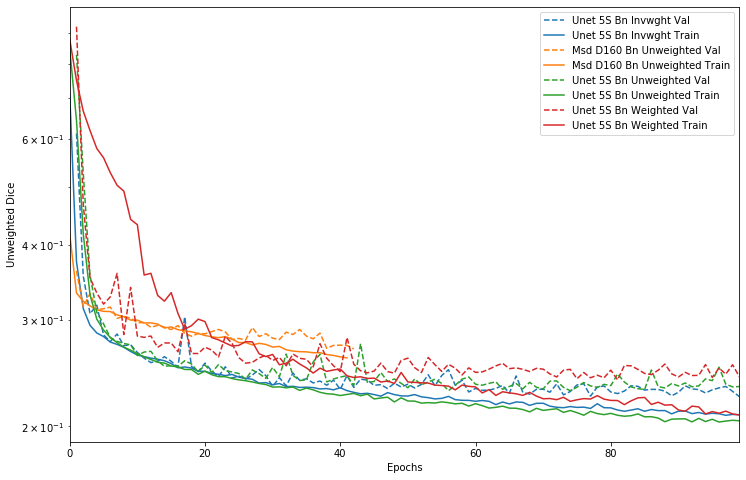

In [26]:
import pandas as pd
from pandas import Timestamp

logfiles = log_dir.glob('run-*.json')
re_tb = re.compile(r'run-(\w+)_logs_(\w+)-tag-epoch_(\w+)\.json$')

log_histories = {}
for logfile in logfiles:
    match = re_tb.search(logfile.name)
    if not match:
        continue
    model_name, data_name, var_name = match.groups()
    
    with open(logfile, 'r') as f:
        log_history = json.load(f)
    log_history = np.array(log_history)
    log_history = {
        'time': [Timestamp(t, unit='s') for t in log_history[:,0]],
        'epoch': log_history[:,1], 'val': log_history[:,2]
    }
    
    if model_name not in log_histories:
        log_histories[model_name] = {}
    if data_name not in log_histories[model_name]:
        log_histories[model_name][data_name] = {}
    log_histories[model_name][data_name][var_name] = pd.DataFrame(log_history)

plt.figure(figsize=(12,8))

key = 'unweighted_dice'

for name, history in log_histories.items():
    name = name.replace('_', ' ').title()
    val = plt.plot(history['validation'][key]['epoch'] + 1,
                   history['validation'][key]['val'],
                   '--', label=name + ' Val')
    plt.plot(history['train'][key]['epoch'],
             history['train'][key]['val'],
             color=val[0].get_color(), label=name + ' Train')

plt.xlabel('Epochs')
plt.ylabel(key.replace('_',' ').title())
plt.legend()
plt.xlim([0,max([max(h['train'][key]['epoch']) for h in log_histories.values()])])
plt.yscale('log')

plt.show()

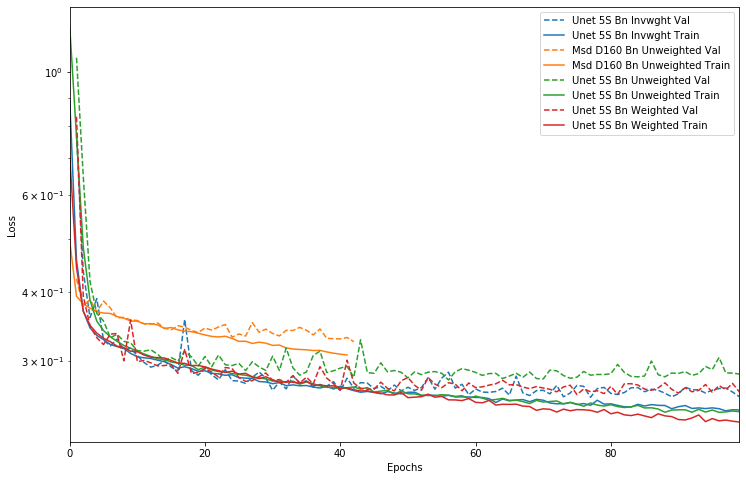

In [28]:
plt.figure(figsize=(12,8))

key = 'loss'

for name, history in log_histories.items():
    name = name.replace('_', ' ').title()
    val = plt.plot(history['validation'][key]['epoch'] + 1,
                   history['validation'][key]['val'],
                   '--', label=name + ' Val')
    plt.plot(history['train'][key]['epoch'],
             history['train'][key]['val'],
             color=val[0].get_color(), label=name + ' Train')

plt.xlabel('Epochs')
plt.ylabel(key.replace('_',' ').title())
plt.legend()
plt.xlim([0,max([max(h['train'][key]['epoch']) for h in log_histories.values()])])
plt.yscale('log')

plt.show()

## Compare performance of models on validation data

In [5]:
from tensorflow.python.keras.models import load_model

custom_objects = {
    'weighted_bce_dice': weighted_bce_dice,
    'unweighted_bce_dice': unweighted_bce_dice,
    'unweighted_dice': unweighted_dice
}

# Initialise a validation data set generator
val_aug = Augmenter(xy_out=96, p_noop=1, probs={'vshift': 0.25, 'hshift': 0.25})
preprocessing_funcs = (robust_norm, logical_norm, raw_norm)
val_gen = Generator(val_data, batch_size=8, aug=val_aug, preprocess=preprocessing_funcs, in_memory=True)

In [ ]:
unet_5s_bn_unweighted = load_model(log_dir / 'unet_5s_bn_unweighted' / 'weights.hdf5', custom_objects=custom_objects)
unet_5s_bn_weighted = load_model(log_dir / 'unet_5s_bn_weighted' / 'weights.hdf5', custom_objects=custom_objects)
unet_5s_bn_invwght = load_model(log_dir / 'unet_5s_bn_invwght' / 'weights.hdf5', custom_objects=custom_objects)

Input images:


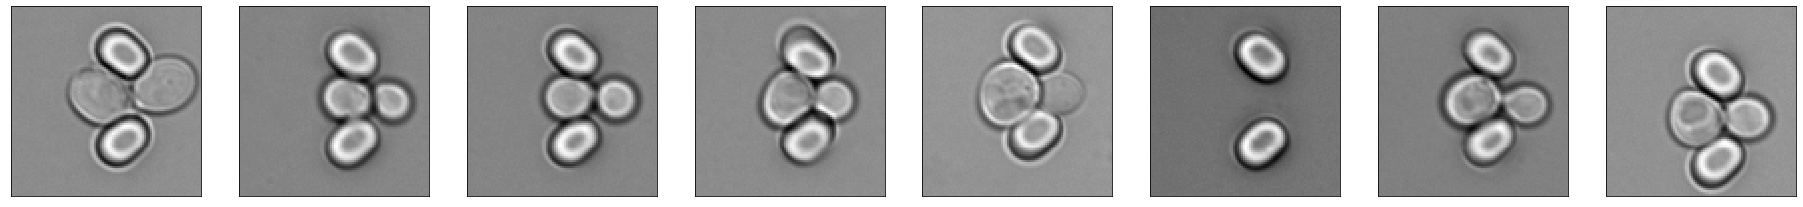

Target images:


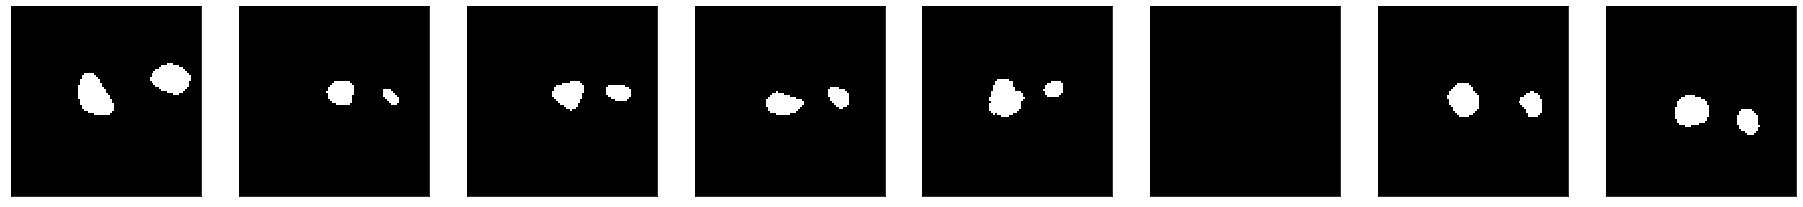

Predicted images:


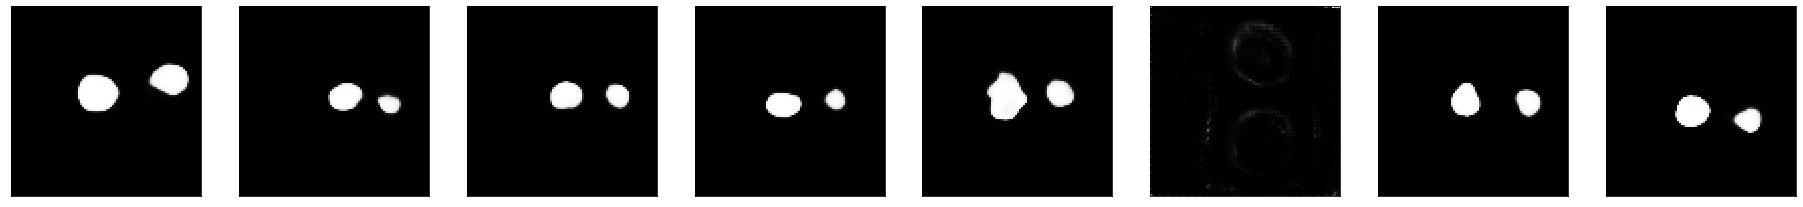

Correct in green; false positives in blue; false negatives in red:


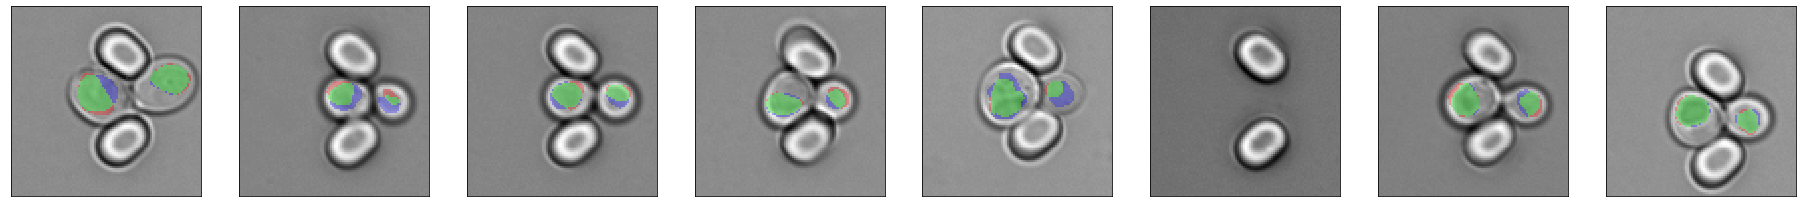

In [7]:
sample_input, sample_target = val_gen[0]
sample_target = sample_target[0][...,0] > 0
sample_pred = unet_5s_bn_unweighted.predict(sample_input)

print('Input images:')
plot_ims(np.split(sample_input[...,0], len(sample_input)))
print('Target images:')
plot_ims(np.split(sample_target, len(sample_target)))
print('Predicted images:')
plot_ims(np.split(sample_pred, len(sample_pred)))

print('Correct in green; false positives in blue; false negatives in red:')

sample_pred_bin = np.squeeze(sample_pred) > 0.5
correct = sample_pred_bin & sample_target
falsepos = sample_pred_bin & ~sample_target
falseneg = ~sample_pred_bin & sample_target

ncols = len(sample_input)
plt.figure(figsize=(ncols * 4, 4))
for i in range(ncols):
    plt.subplot(1, ncols, i + 1)
    plt.imshow(np.squeeze(sample_input[i,:,:,0]), cmap='gray')
    plt.imshow(colour_seg(correct[i], rgb=(0,1,0), alpha=0.3))
    plt.imshow(colour_seg(falsepos[i], rgb=(0,0,1), alpha=0.3))
    plt.imshow(colour_seg(falseneg[i], rgb=(1,0,0), alpha=0.3))
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
plt.show()

unweighted:


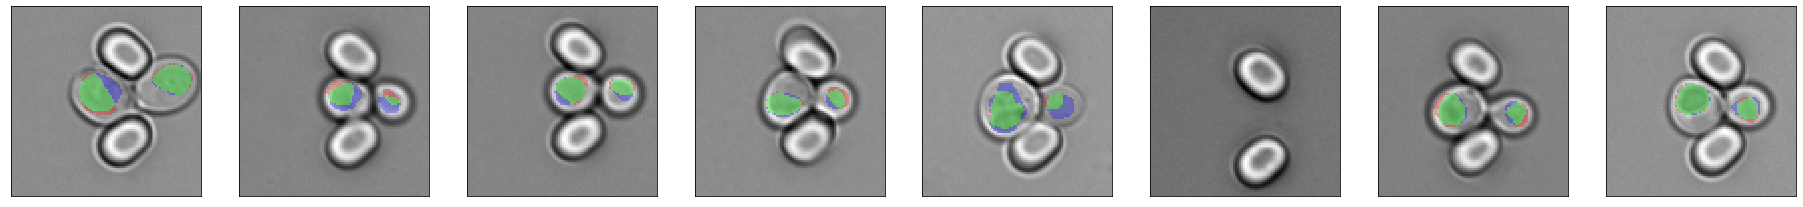

weighted:


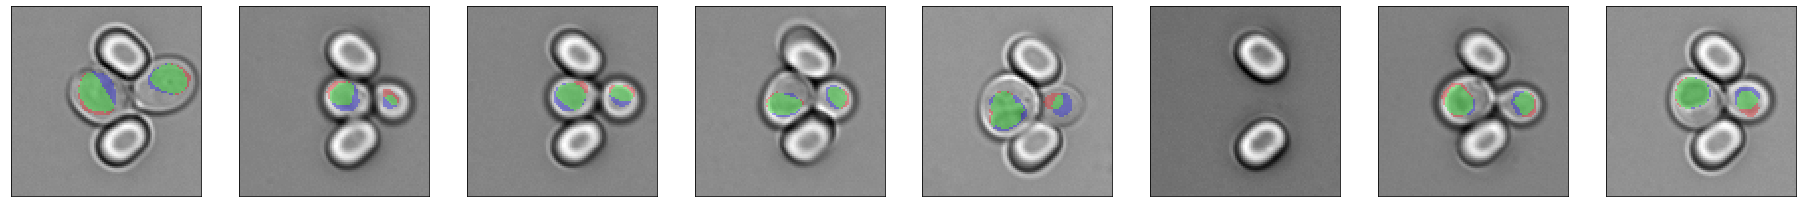

inverse weights:


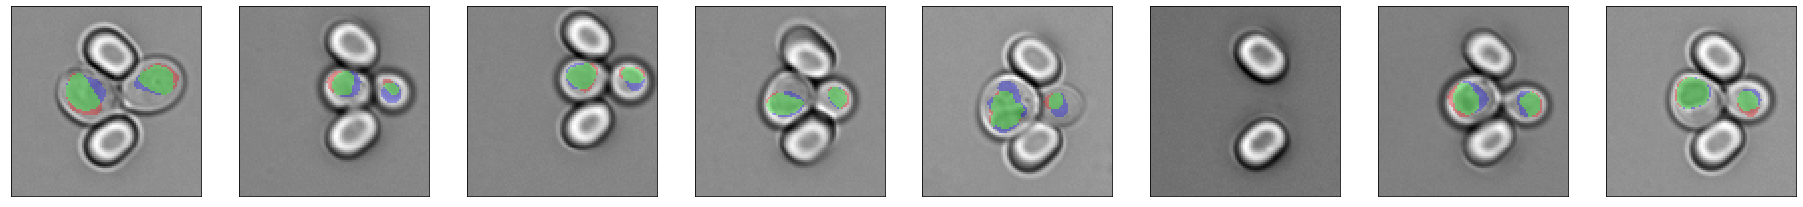

In [9]:
def plot_overlaps(model, inputim, target):
    target = target[0][...,0] > 0
    pred = model.predict(inputim)
    pred_bin = np.squeeze(pred) > 0.5
    correct = pred_bin & target
    falsepos = pred_bin & ~target
    falseneg = ~pred_bin & target

    ncols = len(inputim)
    plt.figure(figsize=(ncols * 4, 4))
    for i in range(ncols):
        plt.subplot(1, ncols, i + 1)
        plt.imshow(np.squeeze(inputim[i,:,:,0]), cmap='gray')
        plt.imshow(colour_seg(correct[i], rgb=(0,1,0), alpha=0.3))
        plt.imshow(colour_seg(falsepos[i], rgb=(0,0,1), alpha=0.3))
        plt.imshow(colour_seg(falseneg[i], rgb=(1,0,0), alpha=0.3))
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
    plt.show()


print('unweighted:')
plot_overlaps(unet_5s_bn_unweighted, *val_gen[0])
print('weighted:')
plot_overlaps(unet_5s_bn_weighted, *val_gen[0])
print('inverse weights:')
plot_overlaps(unet_5s_bn_invwght, *val_gen[0])

**Find best and worst in validation set**

unet_5s_bn_unweighted


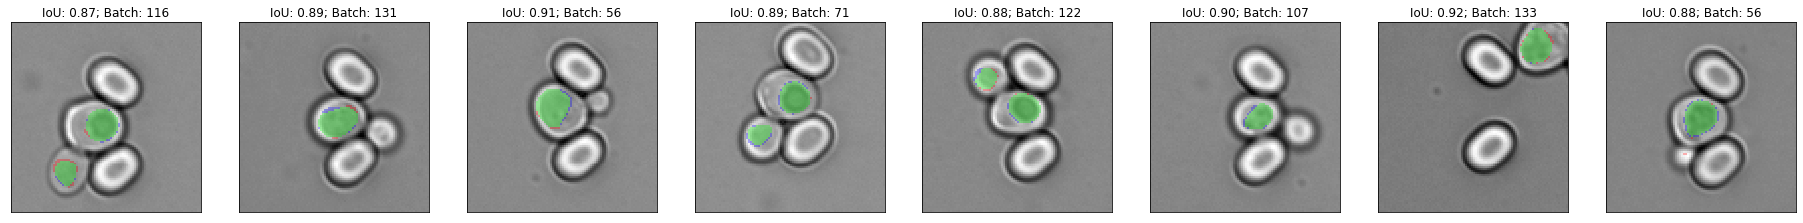

unet_5s_bn_weighted


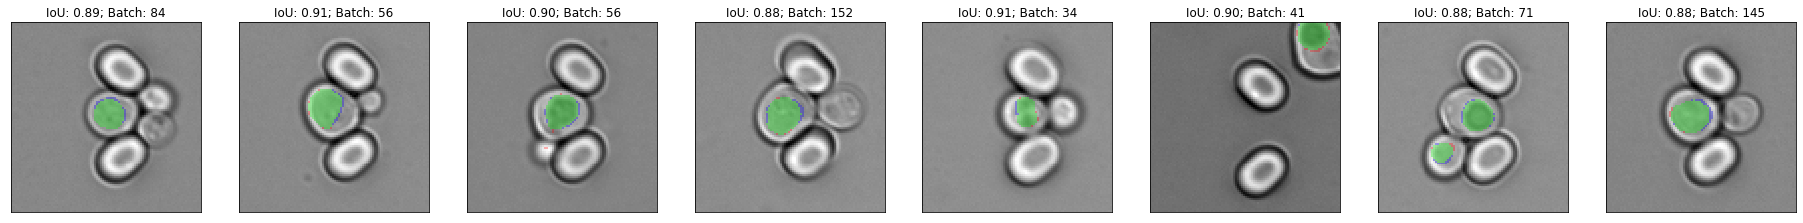

unet_5s_bn_invwght


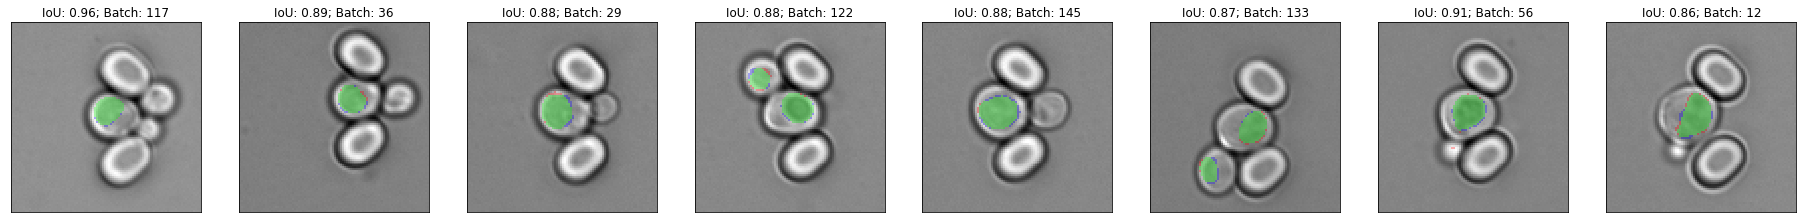

unet_5s_bn_unweighted


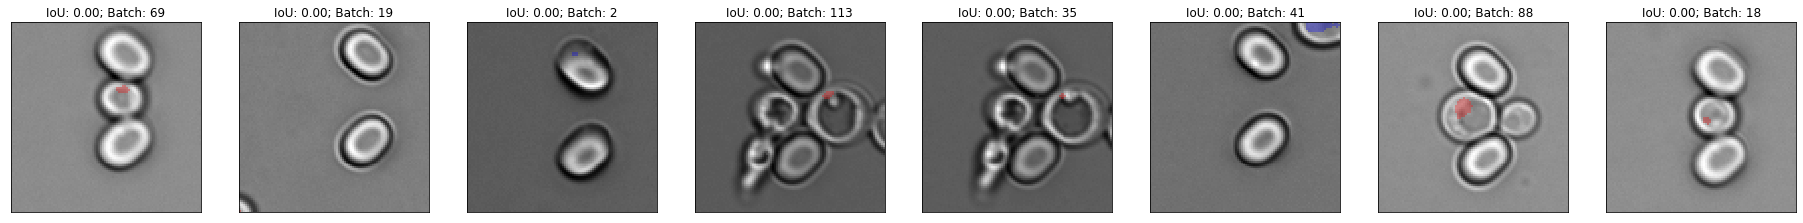

unet_5s_bn_weighted


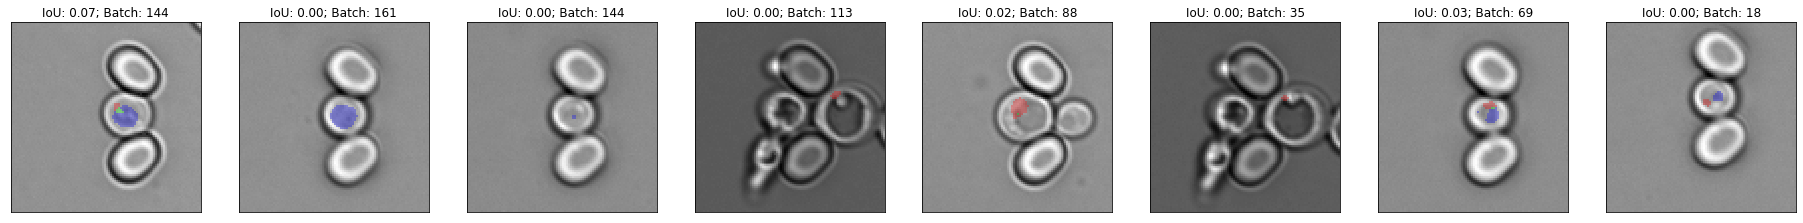

unet_5s_bn_invwght


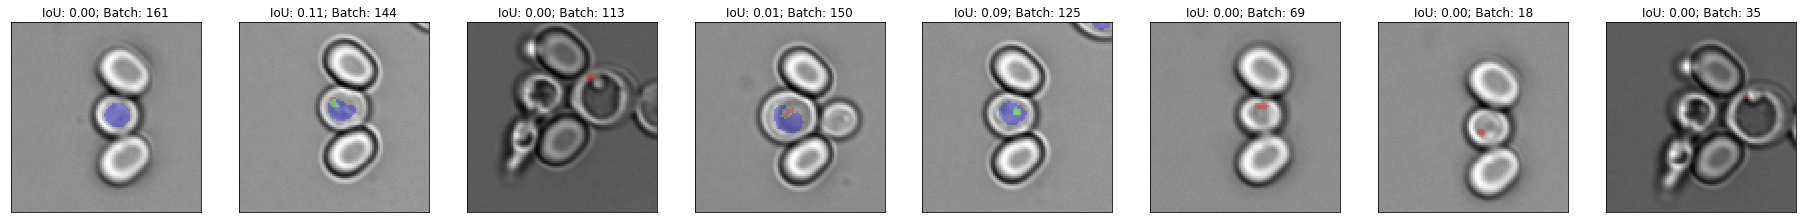

In [24]:
def get_best_and_worst(model, gen):
    best = []
    worst = []
    for i in range(len(gen)):
        inputim, target = gen[i]
        target = target[0][...,0] > 0
        pred = model.predict(inputim)
        pred_bin = np.squeeze(pred) > 0.5
        for p, t, im in zip(pred_bin, target, inputim):
            u = np.sum(p | t)
            if u == 0:
                # Ignore any empty traps
                continue
            iou = np.sum(p & t) / u
            out = (iou, i, p, t, im)
            if len(best)<8:
                best.append(out)
                worst.append(out)
            else:
                best_IoUs = [b[0] for b in best]
                best_minind = np.argmin(best_IoUs)
                if iou > best_IoUs[best_minind]:
                    best[best_minind] = out
                worst_IoUs = [w[0] for w in worst]
                worst_maxind = np.argmax(worst_IoUs)
                if iou < worst_IoUs[worst_maxind]:
                    worst[worst_maxind] = out
        
    return best, worst


def plot_best_or_worst(outlist):
    ncols = len(outlist)
    plt.figure(figsize=(ncols * 4, 4))
    for i in range(ncols):
        iou, batch_ind, pred, target, inputim = outlist[i]
        
        correct = pred & target
        falsepos = pred & ~target
        falseneg = ~pred & target

        plt.subplot(1, ncols, i + 1)
        plt.imshow(np.squeeze(inputim[:,:,0]), cmap='gray')
        plt.imshow(colour_seg(correct, rgb=(0,1,0), alpha=0.3))
        plt.imshow(colour_seg(falsepos, rgb=(0,0,1), alpha=0.3))
        plt.imshow(colour_seg(falseneg, rgb=(1,0,0), alpha=0.3))
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.title('IoU: {:.2f}; Batch: {}'.format(iou, batch_ind))
    plt.show()


unwght_best, unwght_worst = get_best_and_worst(unet_5s_bn_unweighted, val_gen)
wght_best, wght_worst = get_best_and_worst(unet_5s_bn_weighted, val_gen)
invwght_best, invwght_worst = get_best_and_worst(unet_5s_bn_invwght, val_gen)

from IPython.display import HTML

display(HTML('<b>Best</b>'))
print('unet_5s_bn_unweighted')
plot_best_or_worst(unwght_best)
print('unet_5s_bn_weighted')
plot_best_or_worst(wght_best)
print('unet_5s_bn_invwght')
plot_best_or_worst(invwght_best)

display(HTML('<b>Worst</b>'))
print('unet_5s_bn_unweighted')
plot_best_or_worst(unwght_worst)
print('unet_5s_bn_weighted')
plot_best_or_worst(wght_worst)
print('unet_5s_bn_invwght')
plot_best_or_worst(invwght_worst)